In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time, json
import sys
sys.path.append("../")
# sys.path.append("../chess_llm_interpretability")
import os
import torch
import numpy as np

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-10-31 18:34:51 __main__ INFO     torch.__version__='2.5.0+cu124', torch.version.cuda='12.4'


In [3]:
from src.models import ModelandTokenizer

# MODEL_KEY = "meta-llama/Llama-3.2-3B-Instruct"
# MODEL_KEY = "meta-llama/Llama-3.1-8B-Instruct"

# MODEL_KEY = "meta-llama/Llama-3.2-3B"
# MODEL_KEY = "google/gemma-2-2b"
# MODEL_KEY = "meta-llama/Llama-3.1-8B"
MODEL_KEY = "meta-llama/Llama-3.2-3B"

mt = ModelandTokenizer(
    model_key=MODEL_KEY,
    # torch_dtype=torch.float32,
)

2024-10-31 18:34:53 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]

2024-10-31 18:34:56 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.2-3B> | size: 6127.841 MB | dtype: torch.float16 | device: cuda:0


### Verify Causal Tracing

In [4]:
def get_prompt(template, examples, query):
    prompt = ""
    for w1, w2, result in examples:
        prompt += f"{template.format(w1, w2)} {result}\n"
    prompt += f"{template.format(*query)}" 
    return prompt


template = "The Spanish word \"{}\" means \"{}\" in English. This statement is:"
examples = [
    ("aire", "silver", "FALSE"),
    ("jirafa", "giraffe", "TRUE"),
    ("luz", "light", "TRUE"),
    ("mesa", "mat", "False")
]

query_base = ("uno", "floor")
prompt_base = get_prompt(template, examples, query_base)
# print(prompt_patch)

query_patch = ("uno", "one")
prompt_patch = get_prompt(template, examples, query_patch)

In [5]:
print(prompt_base)

The Spanish word "aire" means "silver" in English. This statement is: FALSE
The Spanish word "jirafa" means "giraffe" in English. This statement is: TRUE
The Spanish word "luz" means "light" in English. This statement is: TRUE
The Spanish word "mesa" means "mat" in English. This statement is: False
The Spanish word "uno" means "floor" in English. This statement is:


In [5]:
# prompt_template = "{} is located in the city of"

# clean_subj = "Louvre"
# prompt_base = prompt_template.format(clean_subj)

# patched_subj = "The Space Needle"
# prompt_patch = prompt_template.format(patched_subj)

In [6]:
from src.functional import predict_next_token

base_ans = predict_next_token(
    mt = mt, inputs = prompt_base
)[0][0]

patch_ans = predict_next_token(
    mt = mt, inputs = prompt_patch
)[0][0]

print(f"Base answer: {base_ans}")
print(f"Patch answer: {patch_ans}")

assert base_ans.token_id != patch_ans.token_id, "The answers should be different."

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/torch/_subclasses/fake_tensor.py:2039: UserWarning: Accessing the data pointer of FakeTensor is deprecated and will error in PyTorch 2.5. This is almost definitely a bug in your code and will cause undefined behavior with subsystems like torch.compile. Please wrap calls to tensor.data_ptr() in an opaque custom op; If all else fails, you can guard accesses to tensor.data_ptr() on isinstance(tensor, FakeTensor). (Triggered internally at ../c10/core/StorageImpl.cpp:31.)
  return func(*args, **kwargs)
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Base answer: " FALSE" (p=0.383)
Patch answer: " TRUE" (p=0.555)


In [38]:
from src.trace import trace_important_states

# trace_results = trace_important_states(
#     mt=mt,
#     prompt_template=prompt_template,
#     clean_subj=clean_subj,
#     patched_subj=patched_subj,
#     window_size=1
# )

trace_results = trace_important_states(
    mt=mt,
    prompt_template=prompt_base.replace(query_base[1], "{}"),
    clean_subj=query_base[1],
    patched_subj=query_patch[1],
    window_size=1,
    ignore_few_shot_examples=True,
    few_shot_delimiter="\n"
)

tensor(128000, device='cuda:0') [128000, 128001]
2024-10-23 14:50:32 src.trace DEBUG    1
The Spanish word "aire" means "silver" in English. This statement is: FALSE
The Spanish word "jirafa" means "giraffe" in English. This statement is: TRUE
The Spanish word "luz" means "light" in English. This statement is: TRUE
The Spanish word "mesa" means "mat" in English. This statement is: False
The Spanish word "uno" means "floor" in English. This statement is:
2024-10-23 14:50:32 src.trace DEBUG    trace_start_idx updated to 82
2024-10-23 14:50:32 src.trace DEBUG    82
2024-10-23 14:50:35 src.trace DEBUG    answer=PredictedToken(token=' TRUE', prob=0.5550426840782166, logit=22.734375, token_id=8378)
2024-10-23 14:50:35 src.trace DEBUG    clean_answer=PredictedToken(token=' FALSE', prob=0.38274797797203064, logit=22.15625, token_id=7989)
2024-10-23 14:50:35 src.trace DEBUG    track_ans=[(3, PredictedToken(token=' TRUE', prob=0.15707945823669434, logit=21.265625, token_id=8378))]
2024-10-23 14:

100%|██████████| 504/504 [04:21<00:00,  1.92it/s]


2024-10-23 14:55:12 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2024-10-23 14:55:12 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-10-23 14:55:12 matplotlib DEBUG    interactive is False
2024-10-23 14:55:12 matplotlib DEBUG    platform is linux
2024-10-23 14:55:12 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json


2024-10-23 14:55:12 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-23 14:55:12 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='norm

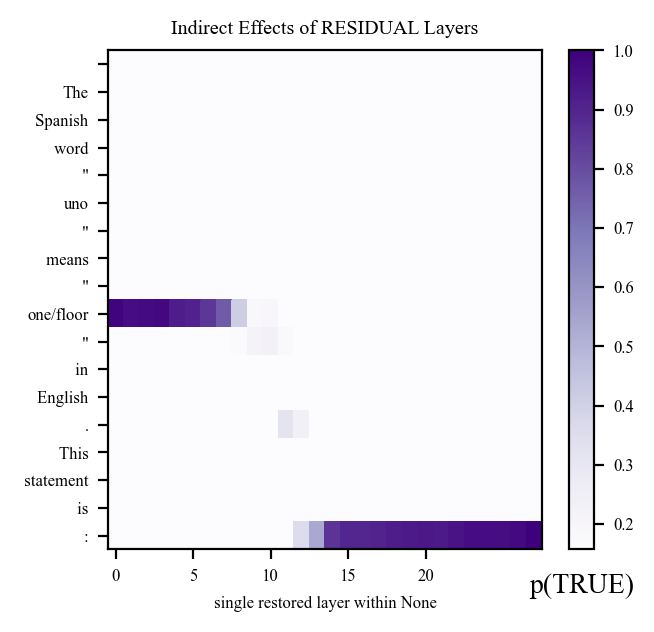

In [39]:
from src.plotting import plot_trace_heatmap

plot_trace_heatmap(trace_results)

### Dataset Parsing (outdated)

In [ ]:
from src.dataset import GMTDataset

ds_sp_en = GMTDataset.from_csv("sp_en_trans.csv", "SP to EN")

2024-10-24 15:16:20 numexpr.utils INFO     Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-10-24 15:16:20 numexpr.utils INFO     NumExpr defaulting to 8 threads.
2024-10-24 15:16:20 src.dataset DEBUG    initialized SP to EN with 348 examples.


In [ ]:
ds_cities = GMTDataset.from_csv(
    [
        # "sp_en_trans.csv", 
        "cities.csv"
    ], 
    "Cities"
)

2024-10-24 15:16:20 src.dataset DEBUG    initialized Cities with 1493 examples.


In [9]:
ds_cities.select_few_shot(0)
ds_sp_en.select_few_shot(0)

In [10]:
ques, ans = ds_cities[25]

print(f"\"{ques}\"")
print(f"\"{ans}\"")

"The city of Kano is in China. This statement is:"
" FALSE"


### Loading Data

In [4]:
from src.dataset_manager import DatasetManager

list(DatasetManager.list_datasets_by_group().keys())

2024-10-31 18:34:57 numexpr.utils INFO     Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-10-31 18:34:57 numexpr.utils INFO     NumExpr defaulting to 8 threads.


2024-10-31 18:34:57 datasets INFO     PyTorch version 2.5.0 available.


['geometry_of_truth',
 'relations',
 'sst2',
 'md_gender',
 'snli',
 'ag_news',
 'ner',
 'tense',
 'language_identification',
 'singular_plural']

In [27]:
from src.dataset_manager import DatasetManager
from src.functional import get_batch_concept_activations

# group_name, ds_name = "singular_plural", "singular_plural"
# group_name = "geometry_of_truth"
# group_name = "md_gender"
# group_name = "singular_plural"
# group_name = "tense"
# group_name="ag_news"
# group_name = "language_identification"
group_name = "ner"


if group_name in ["language_identification", "ag_news"]:
    tokenization_kwargs = {
        "padding": "max_length",
        "max_length": 200,
        "truncation": True,
    }
else:
    tokenization_kwargs = {
        "padding": "longest",
    }

dataloader = DatasetManager.from_dataset_group(
    group=group_name,
    batch_size=32
)

# dataloader = DatasetManager.from_named_datasets(
#     [(group_name, "sp_en_trans")],
#     batch_size=32
# )

# batch = next(iter(dataloader))
# batch

Reading NER dataset
Processing NER dataset


100%|██████████| 47959/47959 [00:07<00:00, 6274.68it/s]


In [28]:
batch = next(iter(dataloader))
batch

[ContextQASample(context='A.U. troops in Darfur are not mandated to protect civilians .', questions=['# Is Senator John Kerry in any part of this passage?', '# Does Darfur show up anywhere in this text?', '# Is A.U. referenced in this text?', '# Does this passage make any reference to Rae Bareli?', '# Does Darfur appear in this text?', '# Does this text refer to Darfur?', '# Does this document contain any mentions of President Viktor Yanukovych?', '# Is within 25 discussed anywhere in this content?', '# Can you find any references to A.U. in this text?', '# Is there any mention of A.U. throughout this material?'], answers=['No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes'], ds_label=None),
 ContextQASample(context='The raids ended with the death of alleged extremist bombmaker Azahari bin Husin .', questions=['# Can you identify any mentions of Azahari bin Husin in this piece?', '# Does between December 11 and 18 show up anywhere in this text?', '# Does Chang Ching-hsi ap

: 

In [16]:
from src.functional import free_gpu_cache

def get_X_y(dataloader, mt, limit = 1000, layer_indices = list(range(mt.n_layer))):
    labels = []

    activations = []
    for batch in dataloader:
        batch_prompts = [b.context for b in batch]
        labels.extend([b.ds_label for b in batch])
        latents = get_batch_concept_activations(
            mt=mt,
            prompts=batch_prompts,
            interested_layer_indices=layer_indices,
            check_prediction=None,
            on_token_occur=None,
            tokenization_kwargs=tokenization_kwargs,
            device="cpu",
        )
        activations.extend(latents)
        limit -= len(batch)
        if limit <= 0:
            break
        
        free_gpu_cache()
    
    return activations, labels

activations, labels = get_X_y(
    dataloader, mt, 
    limit = 2000, 
    layer_indices = list(range(mt.n_layer))
)

In [17]:
len(activations)

2000

### Check separability of labels

In [18]:
from src.analysis import PCA

layer = mt.layer_name_format.format(14)

X = torch.stack(
    [a.latents[layer] for a in activations]
).to(torch.float32).to("cuda")

y = labels
# y = ["True" if l == "1" else "False" for l in labels]

pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

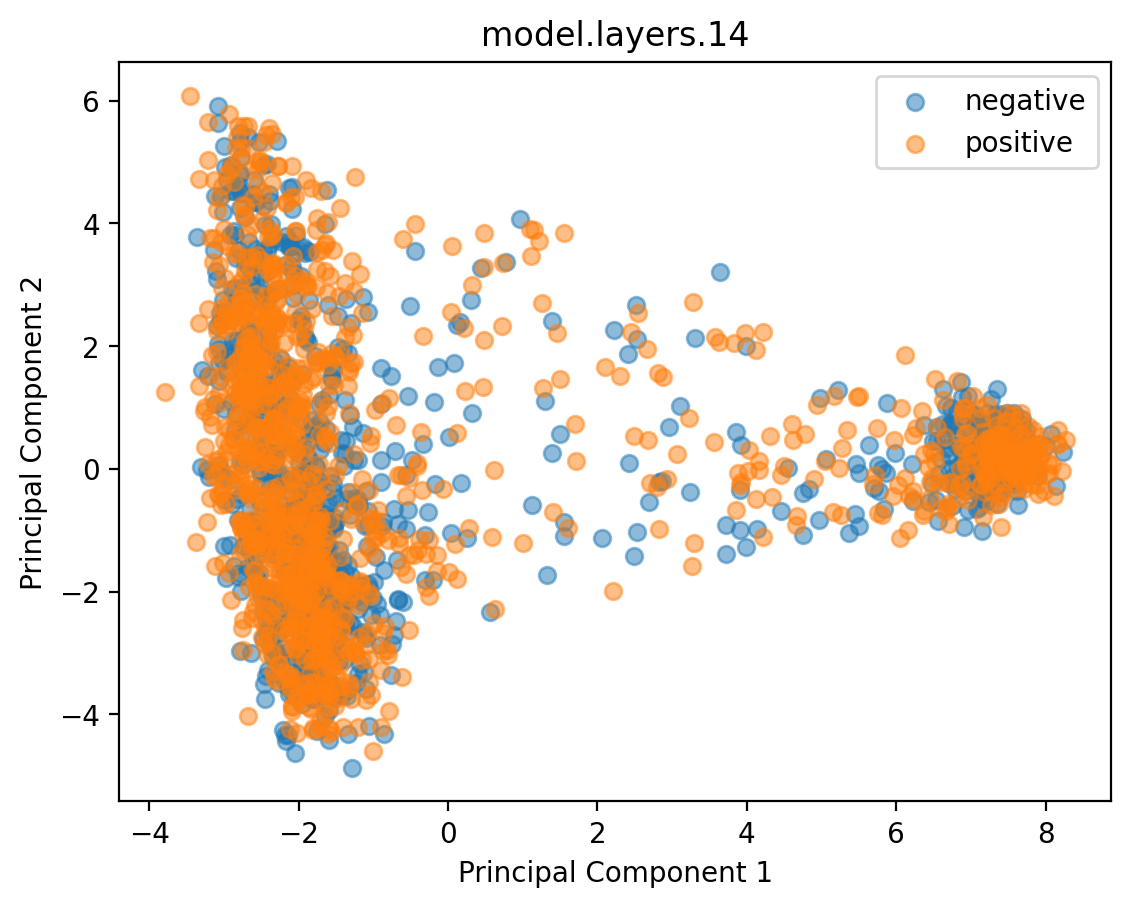

In [19]:
import matplotlib.pyplot as plt

def show_scatter_plot(X, y):
    plt.rcParams["figure.dpi"] = 200
    points_by_label = {l: [] for l in set(y)}
    for point, label in zip(X, y):
        points_by_label[label].append(point.cpu())

    for l in points_by_label:
        points_by_label[l] = np.array(points_by_label[l])
        plt.scatter(points_by_label[l][:, 0], points_by_label[l][:, 1], label=l, alpha=0.5) 

    plt.legend()
    plt.title(layer)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.show()

show_scatter_plot(X2, y) 

In [20]:
from src.functional import free_gpu_cache
free_gpu_cache()

### Linear Probe Pipeline

In [21]:
from src.analysis import LinearProbe
# probe = LinearProbe(input_dim=X.shape[1], n_classes=len(set(y)))

train_split = int(len(X) * 0.7)

probe = LinearProbe.from_data(
    X[:train_split], y[:train_split], 
    epochs=1000,
    validation_set=(X[train_split:], y[train_split:]),
)
probe

2024-10-31 18:40:47 src.analysis DEBUG    Epoch 100/1000, Loss: 0.5883985161781311, Validation Accuracy: 0.7633
2024-10-31 18:40:47 src.analysis DEBUG    Epoch 200/1000, Loss: 0.5242310762405396, Validation Accuracy: 0.8450
2024-10-31 18:40:47 src.analysis DEBUG    Epoch 300/1000, Loss: 0.48719507455825806, Validation Accuracy: 0.8600
2024-10-31 18:40:47 src.analysis DEBUG    Epoch 400/1000, Loss: 0.4625215232372284, Validation Accuracy: 0.8717
2024-10-31 18:40:47 src.analysis DEBUG    Epoch 500/1000, Loss: 0.44448068737983704, Validation Accuracy: 0.8750
2024-10-31 18:40:47 src.analysis DEBUG    Epoch 600/1000, Loss: 0.430428683757782, Validation Accuracy: 0.8850
2024-10-31 18:40:47 src.analysis DEBUG    Epoch 700/1000, Loss: 0.418982595205307, Validation Accuracy: 0.8883
2024-10-31 18:40:47 src.analysis DEBUG    Epoch 800/1000, Loss: 0.4093562662601471, Validation Accuracy: 0.8900
2024-10-31 18:40:47 src.analysis DEBUG    Epoch 900/1000, Loss: 0.4010823667049408, Validation Accuracy:

LinearProbe(
  (linear): Linear(in_features=3072, out_features=2, bias=False)
  (class_head): Softmax(dim=-1)
)

In [22]:
probe.validate(X[train_split:], y[train_split:])

0.8916666666666667

### Test concept presence with linear probe

In [23]:
def check_concept_presence_with_LR(
    activations,
    labels,
    layer_name_format,
    interested_layer_indices,
    device = "cuda",
    validation_split = 0.2,
    test_activations = None,
):
    validation_acc = []
    ood_test_acc = []

    train_split = int(len(activations) * (1 - validation_split))

    for l_idx in interested_layer_indices:
        layer_name = layer_name_format.format(l_idx)
        
        layer_X = torch.stack(
            [a.latents[layer_name] for a in activations]
        ).to(torch.float32).to("cuda")
        layer_y = labels

        probe = LinearProbe.from_data(
            layer_X[:train_split], layer_y[:train_split], 
            epochs=1000,
            name=layer_name,
            print_logs=False
        )

        val_acc = probe.validate(layer_X[train_split:], layer_y[train_split:])
        validation_acc.append(val_acc)

        log_msg = f"{layer_name}: {val_acc:.4f}"

        if test_activations is not None:
            layer_X_test = torch.stack([l["latents"][layer_name] for l in test_activations]).to(torch.float32).to(device)
            layer_y_test = [l["answer"] for l in test_activations]

            test_acc = probe.validate(layer_X_test, layer_y_test)
            ood_test_acc.append(test_acc)
            log_msg += f", test acc: {test_acc:.4f}"
        
        logger.info(log_msg)
        
    if ood_test_acc:
        return validation_acc, ood_test_acc
    return validation_acc


# Check concept presence with linear regression
val_acc = check_concept_presence_with_LR(
    activations=activations, labels=labels,
    layer_name_format=mt.layer_name_format,
    interested_layer_indices=list(range(mt.n_layer)),
)


2024-10-31 18:40:50 __main__ INFO     model.layers.0: 0.6300
2024-10-31 18:40:51 __main__ INFO     model.layers.1: 0.6625
2024-10-31 18:40:51 __main__ INFO     model.layers.2: 0.7025
2024-10-31 18:40:52 __main__ INFO     model.layers.3: 0.7575
2024-10-31 18:40:52 __main__ INFO     model.layers.4: 0.8125
2024-10-31 18:40:53 __main__ INFO     model.layers.5: 0.8200
2024-10-31 18:40:53 __main__ INFO     model.layers.6: 0.8300
2024-10-31 18:40:53 __main__ INFO     model.layers.7: 0.8725
2024-10-31 18:40:54 __main__ INFO     model.layers.8: 0.8725
2024-10-31 18:40:54 __main__ INFO     model.layers.9: 0.8925
2024-10-31 18:40:55 __main__ INFO     model.layers.10: 0.8800
2024-10-31 18:40:55 __main__ INFO     model.layers.11: 0.8950
2024-10-31 18:40:55 __main__ INFO     model.layers.12: 0.8950
2024-10-31 18:40:56 __main__ INFO     model.layers.13: 0.8825
2024-10-31 18:40:56 __main__ INFO     model.layers.14: 0.8900
2024-10-31 18:40:56 __main__ INFO     model.layers.15: 0.8775
2024-10-31 18:40:5

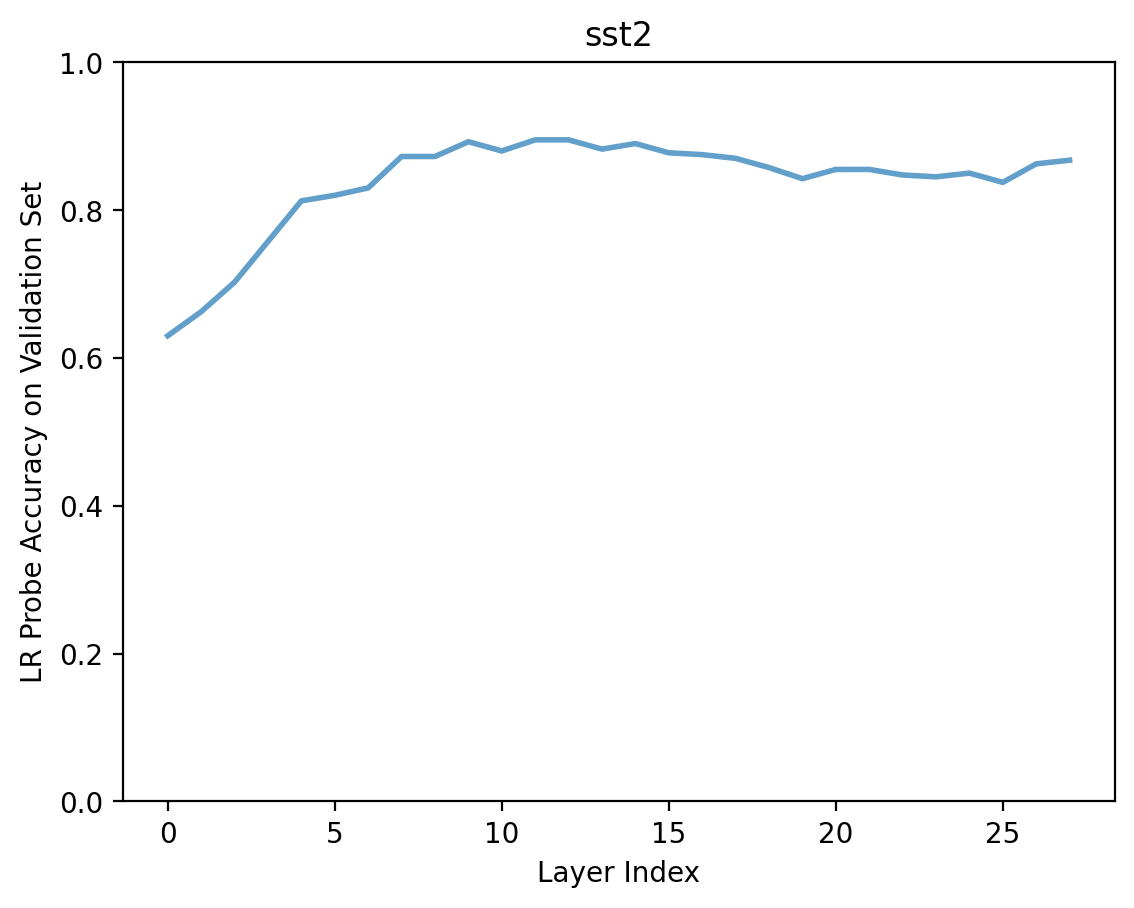

In [24]:
from matplotlib import pyplot as plt

plt.plot(val_acc, linewidth=2, alpha=0.7, label='Validation Accuracy')
# plt.plot(ood_acc, linewidth=2, alpha=0.7, label='OOD Test Accuracy')
plt.xlabel('Layer Index')
plt.ylabel('LR Probe Accuracy on Validation Set')
plt.title(group_name)
# plt.legend()
plt.ylim(0, 1)
plt.show()